# Tf-idf

In [104]:
import re
import pathlib
import pandas as pd
import numpy as np

In [123]:
pathfile = r'E:\STUDY\8PM9I\UIRS'
dataset_file = pathlib.Path(pathfile).joinpath('temp')

In [124]:
class Patient:
    def __init__(self):
        self.treatment_days = []
    def __len__(self):
        return len(self.treatment_days)

In [148]:
docs = (file for file in dataset_file.iterdir() if file.suffix == '.txt')

date_pattern = re.compile(r'\d\d[.]\d\d[.]\d\d\d\d')

patients = []
for patientfile in docs:
    with open(patientfile, 'rt') as pf: 
        patient = Patient()
        for i, day in enumerate(pf):
            day = re.sub(date_pattern, '', day)
            day = re.sub('\n', '', day)
            patient.treatment_days.append(day)
    patients.append(patient)

[' Жалобы: На распирающую боль, жжение, зуд в области левой голени, общее недомогание, слабость, разбитость, повышение температуры до 38,6. Локальный статус: на левой голени эритема с множеством геморрагий, границы, четкие, горячая на ощупь, отек мягких тканей умеренно выражен, тестоватой консистенции, болезненность по периферии преобладает.',
 ' Жалобы: На умеренную боль ',
 ' Жалобы: Чувствует себя лучше, температура нормальная, местные явления начали регрессировать, меньше отек и гиперемия. Локальный статус: На левой голени эритема, болезненность незначительная. Паховые лимфатические узлы слева слегка слегка болезненны.',
 ' Локальный статус: Паховые лимфатические узлы слева слегка безболезненны.',
 ' Жалобы: Местные явления существенно меньше. Локальный статус: На левой голени эритема стала значительно бледнее.',
 ' Жалобы: Местные явления существенно меньше. Локальный статус: На левой голени эритема стала значительно бледнее.',
 ' Локальный статус: На голени бледнеющая гиперемия, 

In [149]:
"""Заполнить незаолненные дни предыдущим днем (сичтаем, что состояние пациента не изменилось)"""
for paient in patients:
    for i, day in enumerate(patient.treatment_days):
        if day == '' or day == ' ':
            patient.treatment_days[i] = patient.treatment_days[i-1]
    
patients[0].treatment_days

[' Жалобы: На распирающую боль, жжение, зуд в области левой голени, общее недомогание, слабость, разбитость, повышение температуры до 38,6. Локальный статус: на левой голени эритема с множеством геморрагий, границы, четкие, горячая на ощупь, отек мягких тканей умеренно выражен, тестоватой консистенции, болезненность по периферии преобладает.',
 ' Жалобы: На умеренную боль ',
 ' Жалобы: Чувствует себя лучше, температура нормальная, местные явления начали регрессировать, меньше отек и гиперемия. Локальный статус: На левой голени эритема, болезненность незначительная. Паховые лимфатические узлы слева слегка слегка болезненны.',
 ' Локальный статус: Паховые лимфатические узлы слева слегка безболезненны.',
 ' Жалобы: Местные явления существенно меньше. Локальный статус: На левой голени эритема стала значительно бледнее.',
 ' Жалобы: Местные явления существенно меньше. Локальный статус: На левой голени эритема стала значительно бледнее.',
 ' Локальный статус: На голени бледнеющая гиперемия, 

In [151]:
from nltk.corpus import stopwords


additional_stop_words = ['дата','время','осмотра','номер','пациента', 'локальный','статус','осмотр']
russian_stopwords = stopwords.words("russian")
russian_stopwords += additional_stop_words
print(russian_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1, 3))

treatment_days = patients[0].treatment_days
matrix = vectorizer.fit_transform(treatment_days).toarray()
matrix.shape

(12, 249)

In [161]:
"""Stemmization"""
from nltk.stem.snowball import SnowballStemmer

feature_names = vectorizer.get_feature_names()

stemmer = SnowballStemmer("russian") 

feature_names = [stemmer.stem(word) for word in feature_names]
print(feature_names)

['38', '38 лев', '38 левой голен', 'безболезнен', 'бледн', 'бледнеющ', 'бледнеющая гиперем', 'бледнеющая гиперемия отцвета', 'болезнен', 'болезненность незначительн', 'болезненность незначительная пахов', 'болезненность перифер', 'болезненность периферии преоблада', 'болезнен', 'бол', 'боль жжен', 'боль жжение зуд', 'боль практическ', 'боль практически прошл', 'выраж', 'выражен тестоват', 'выражен тестоватой консистенц', 'геморраг', 'геморрагии отек', 'геморрагии отек незначительн', 'геморраг', 'геморрагий границ', 'геморрагий границы четк', 'гиперем', 'гиперемия лев', 'гиперемия левой голен', 'гиперемия отцвета', 'гиперемия отцветающие геморраг', 'голен', 'голени бледнеющ', 'голени бледнеющая гиперем', 'голени общ', 'голени общее недомоган', 'голени оста', 'голени остается шелушен', 'голени эритем', 'голени эритема болезнен', 'голени эритема множеств', 'голени эритема ста', 'горяч', 'горячая ощуп', 'горячая ощупь отек', 'границ', 'границы четк', 'границы четкие горяч', 'жалоб', 'жалоб

In [9]:
"""word = tf-idf"""
patient_history = []
for day in matrix:
    tfidf_scores = {}
    for score, word in zip(day, feature_names):
        tfidf_scores[word] = score
    patient_history.append(tfidf_scores)


            
        

In [11]:
"""Pandas dataframe"""
df = pd.DataFrame(data=patient_history)
df

,бисакод,бисакодила диурез,бисакодила диурез патолог,бол,боли слаб,боли слабость стул,волосист,волосистой част,волосистой части голов,выздоровлен,...,части головы эритем,части справ,части справа эритем,шелушен,шелушение кож,эритем,эритема неровн,эритема неровными кра,эритема угасл,эритема угасла отек
0,0.205859,0.205859,0.205859,0.205859,0.205859,0.205859,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.205859,0.205859,0.205859,0.205859,0.205859,0.205859,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.205859,0.205859,0.205859,0.205859,0.205859,0.205859,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073655,0.073655,0.073655,0.000000,...,0.000000,0.146304,0.146304,0.073655,0.073655,0.073655,0.146304,0.146304,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,...,0.191236,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,0.000000,0.191236,0.191236
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,...,0.191236,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,0.000000,0.191236,0.191236
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,...,0.191236,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,0.000000,0.191236,0.191236
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,...,0.191236,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,0.000000,0.191236,0.191236
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,...,0.191236,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,0.000000,0.191236,0.191236
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,...,0.191236,0.000000,0.000000,0.174643,0.174643,0.174643,0.000000,0.000000,0.191236,0.191236


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X  = df.iloc[:,:].values
X.shape

(11, 105)

In [13]:
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
#eigen_vals

c:\users\roman\appdata\local\programs\python\python36\lib\site-packages\matplotlib\transforms.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
c:\users\roman\appdata\local\programs\python\python36\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


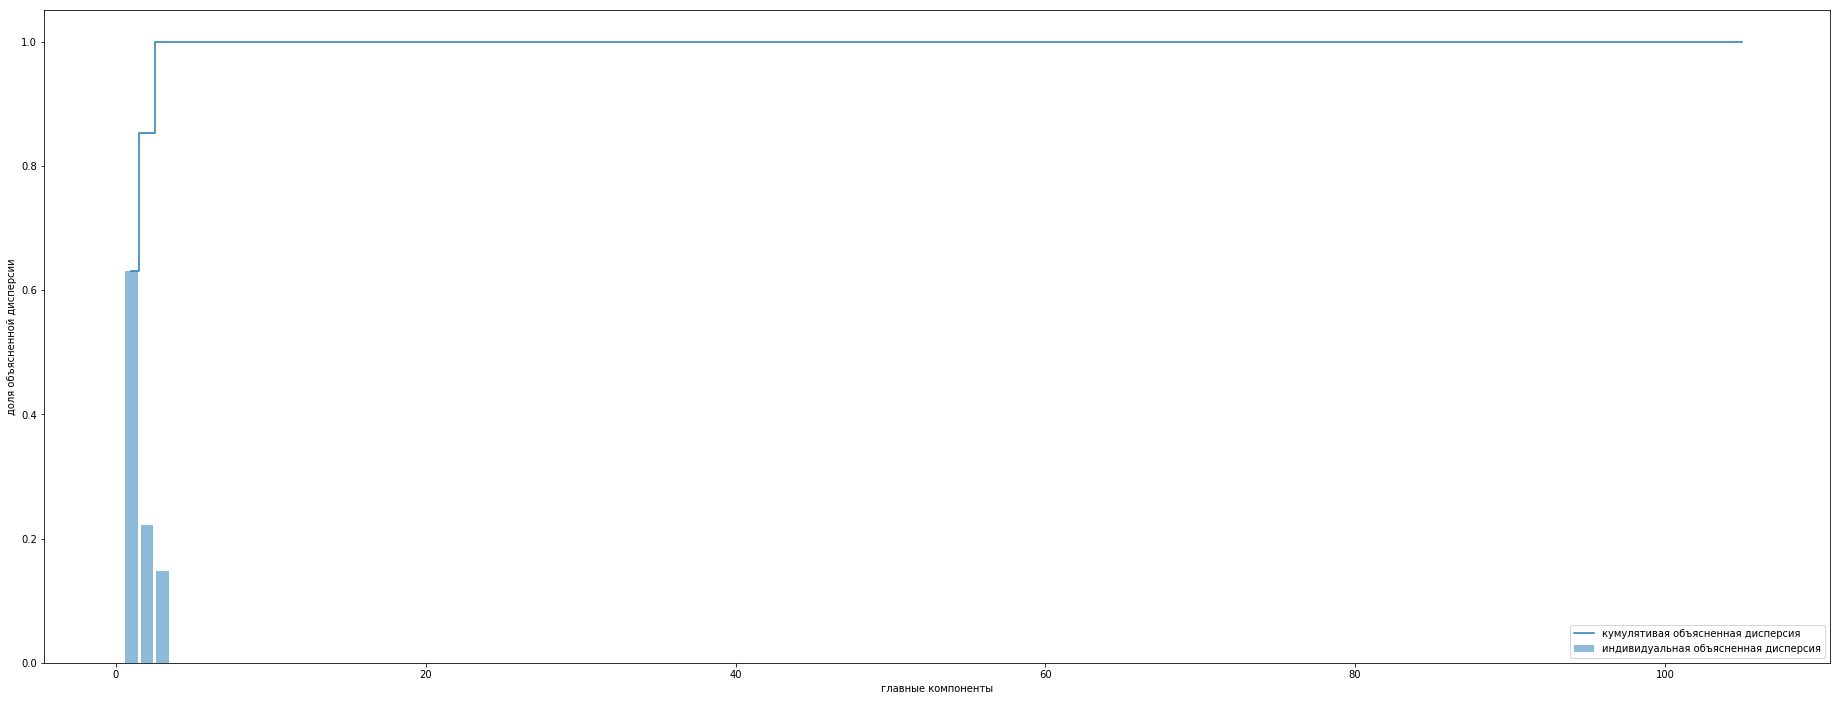

In [16]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
          sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(32,12))
plt.bar(range(1,X.shape[1]+1), var_exp, alpha=0.5, align='center', label='индивидуальная объясненная дисперсия')
plt.step(range(1,X.shape[1]+1), cum_var_exp, where='mid', label='кумулятивая объясненная дисперсия')
plt.ylabel('доля объясненной дисперсии')
plt.xlabel('главные компоненты')
plt.legend(loc='best')
plt.show()

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
cum_var_exp 

array([0.63018547, 0.85209853, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [18]:

# plt.bar(range(0,X.shape[0]), pca.explained_variance_ratio_, alpha=0.5, align='center', label='индивидуальная объясненная дисперсия')
# plt.step(range(0,X.shape[1]), cum_var_exp, where='mid', label='кумулятивая объясненная дисперсия')
# plt.ylabel('доля объясненной дисперсии')
# plt.xlabel('главные компоненты')
# plt.legend(loc='best')
# plt.show()

бисакод
бисакодила диурез
бисакодила диурез патолог
бол
боли слаб
боли слабость стул
волосист
волосистой част
волосистой части голов
выздоровлен
выписыва


IndexError: index 11 is out of bounds for axis 0 with size 11

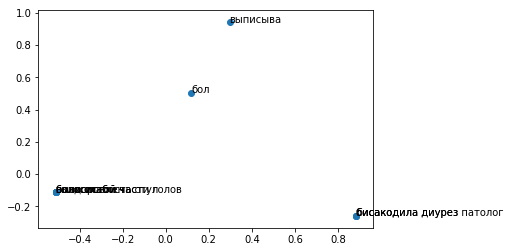

In [19]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(feature_names):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    print(word)
plt.show()